# Решение

## Подготовка

Импортируем необходимые для начала работы библиотеки

In [1]:
import os
import numpy as np
import pandas as pd

Определяем папку, где находятся данные

In [2]:
data_dir = os.path.join('..', 'data')

Загружаем данные

In [3]:
users_df = pd.read_csv(os.path.join(data_dir, 'users.tsv'), sep='\t')
history_df = pd.read_csv(os.path.join(data_dir, 'history.tsv'), sep='\t')
validate_df = pd.read_csv(os.path.join(data_dir, 'validate.tsv'), sep='\t')
validate_answers_df = pd.read_csv(os.path.join(data_dir, 'validate_answers.tsv'), sep='\t')

## Работа с "Историей"

Чтобы удобнее было перезапускать частично, периодически будем копировать датафреймы

In [4]:
history = history_df.copy()

In [5]:
history = history[history['cpm'] < history['cpm'].quantile(0.95)]
history = history[history['cpm'] > history['cpm'].quantile(0.05)]
history['cpm'] = np.log1p(history['cpm'])

Проходимся по датафрейму и агрегируем необходимые нам данные

Можно заменить на вызовы методов датафреймов для необходимых агрегаций, но мне показалось, что так может быть быстрее

Основные показатели которые нам нужны - набор выигравших cpm для каждого пользователя и распределение пользователей по площадкам 

In [6]:
user_cpms = {}
publisher_users = {}

for index, row in history.iterrows():
    user_id = str(int(row['user_id']))
    publisher = str(int(row['publisher']))
    cpm = row['cpm']

    if user_id not in user_cpms:
        user_cpms[user_id] = []
    user_cpms[user_id].append(cpm)

    if publisher not in publisher_users:
        publisher_users[publisher] = set()
    publisher_users[publisher].add(user_id)

## Работа с "Рекламой"

Аналогично копируем датафрейм

In [7]:
ads = validate_df.copy()

In [8]:
ads['cpm'] = np.log1p(ads['cpm'])

Далее мы начинаем обходить для каждого рекламного объявления пользователей, которые в нем указаны и создаем фичи на их основе

Как показала практика это одни из самых значимых фичей

`users_power` - это показатель того, сколько человек смотрит рекламы  
не придумал более хорошего названия

In [9]:
def process_ad_users(user_ids, user_cpms):
    users = user_ids.split(',')
    counts = []
    cpms = []
    for user in users:
        if user in user_cpms:
            counts.append(len(user_cpms[user]))
            cpms.append(np.mean(user_cpms[user]))

    return sum(counts), np.mean(counts), np.mean(cpms)

In [10]:
ads[['users_power', 'mean_users_power', 'mean_cpm_per_users']] = ads['user_ids'].apply(
    lambda user_ids: process_ad_users(user_ids, user_cpms)
).apply(pd.Series)

Здесь примерно то же самое, только обходим по площадкам

In [11]:
def process_ad_publishers(publisher_ids, publisher_users):
    publishers = publisher_ids.split(',')
    counts = []
    for publisher in publishers:
        if publisher in publisher_users:
            counts.append(len(publisher_users[publisher]))

    return sum(counts), np.mean(counts)

In [12]:
ads[['users_in_publishers', 'mean_users_in_publishers']] = ads['publishers'].apply(
    lambda publisher_ids: process_ad_publishers(publisher_ids, publisher_users)
).apply(pd.Series)

Попробуем сгенерировать новые фичи на основе имеющихся

In [13]:
ads['hours'] = ads.apply(lambda row: row['hour_end'] - row['hour_start'], axis=1)

ads['users_in_publishers_x_cpm_x_hours'] = ads['users_in_publishers'] * ads['cpm'] * ads['hours']

## Завершение обработки данных

Далее будем приводить всё к виду, в котором будет удобно скармливать данные модели

In [14]:
features = ads.copy()

Тут удаляем совсем неподходящие (по типу) колонки

In [15]:
features = features.drop(columns=['user_ids', 'publishers'])

Тут удаляем уже те, которые нам не нравятся (по влиянию на модель)

In [16]:
features = features.drop(columns=['hour_start', 'hour_end', 'hours'])

In [17]:
targets = validate_answers_df.copy()

Посмотрим на матрицу корреляций и распределение получившихся признаков и первого таргета

In [18]:
features_and_target = features.merge(targets['at_least_one'], left_index=True, right_index=True)

In [19]:
corr = features_and_target.corr()
corr.style.background_gradient(cmap='coolwarm')

,cpm,audience_size,users_power,mean_users_power,mean_cpm_per_users,users_in_publishers,mean_users_in_publishers,users_in_publishers_x_cpm_x_hours,at_least_one
cpm,1.000000,0.000475,0.011124,0.007842,0.006775,0.017962,-0.020849,0.110505,0.237028
audience_size,0.000475,1.000000,0.509351,0.047116,-0.023829,-0.023185,-0.052189,-0.000466,0.020925
users_power,0.011124,0.509351,1.000000,0.783083,-0.144732,-0.024481,-0.025925,0.023718,0.268229
mean_users_power,0.007842,0.047116,0.783083,1.000000,-0.178469,-0.007437,0.028360,0.048234,0.359473
mean_cpm_per_users,0.006775,-0.023829,-0.144732,-0.178469,1.000000,-0.007333,-0.014923,-0.019652,-0.195868
users_in_publishers,0.017962,-0.023185,-0.024481,-0.007437,-0.007333,1.000000,0.505547,0.340144,0.480019
mean_users_in_publishers,-0.020849,-0.052189,-0.025925,0.028360,-0.014923,0.505547,1.000000,0.186258,0.317782
users_in_publishers_x_cpm_x_hours,0.110505,-0.000466,0.023718,0.048234,-0.019652,0.340144,0.186258,1.000000,0.740944
at_least_one,0.237028,0.020925,0.268229,0.359473,-0.195868,0.480019,0.317782,0.740944,1.000000


Видно, что между признаками присутствует некоторая корреляция в некоторых парах, но также мы видим, что один из признаков достоточно сильно коррелирует с таргетом  
Это то, что нам нужно

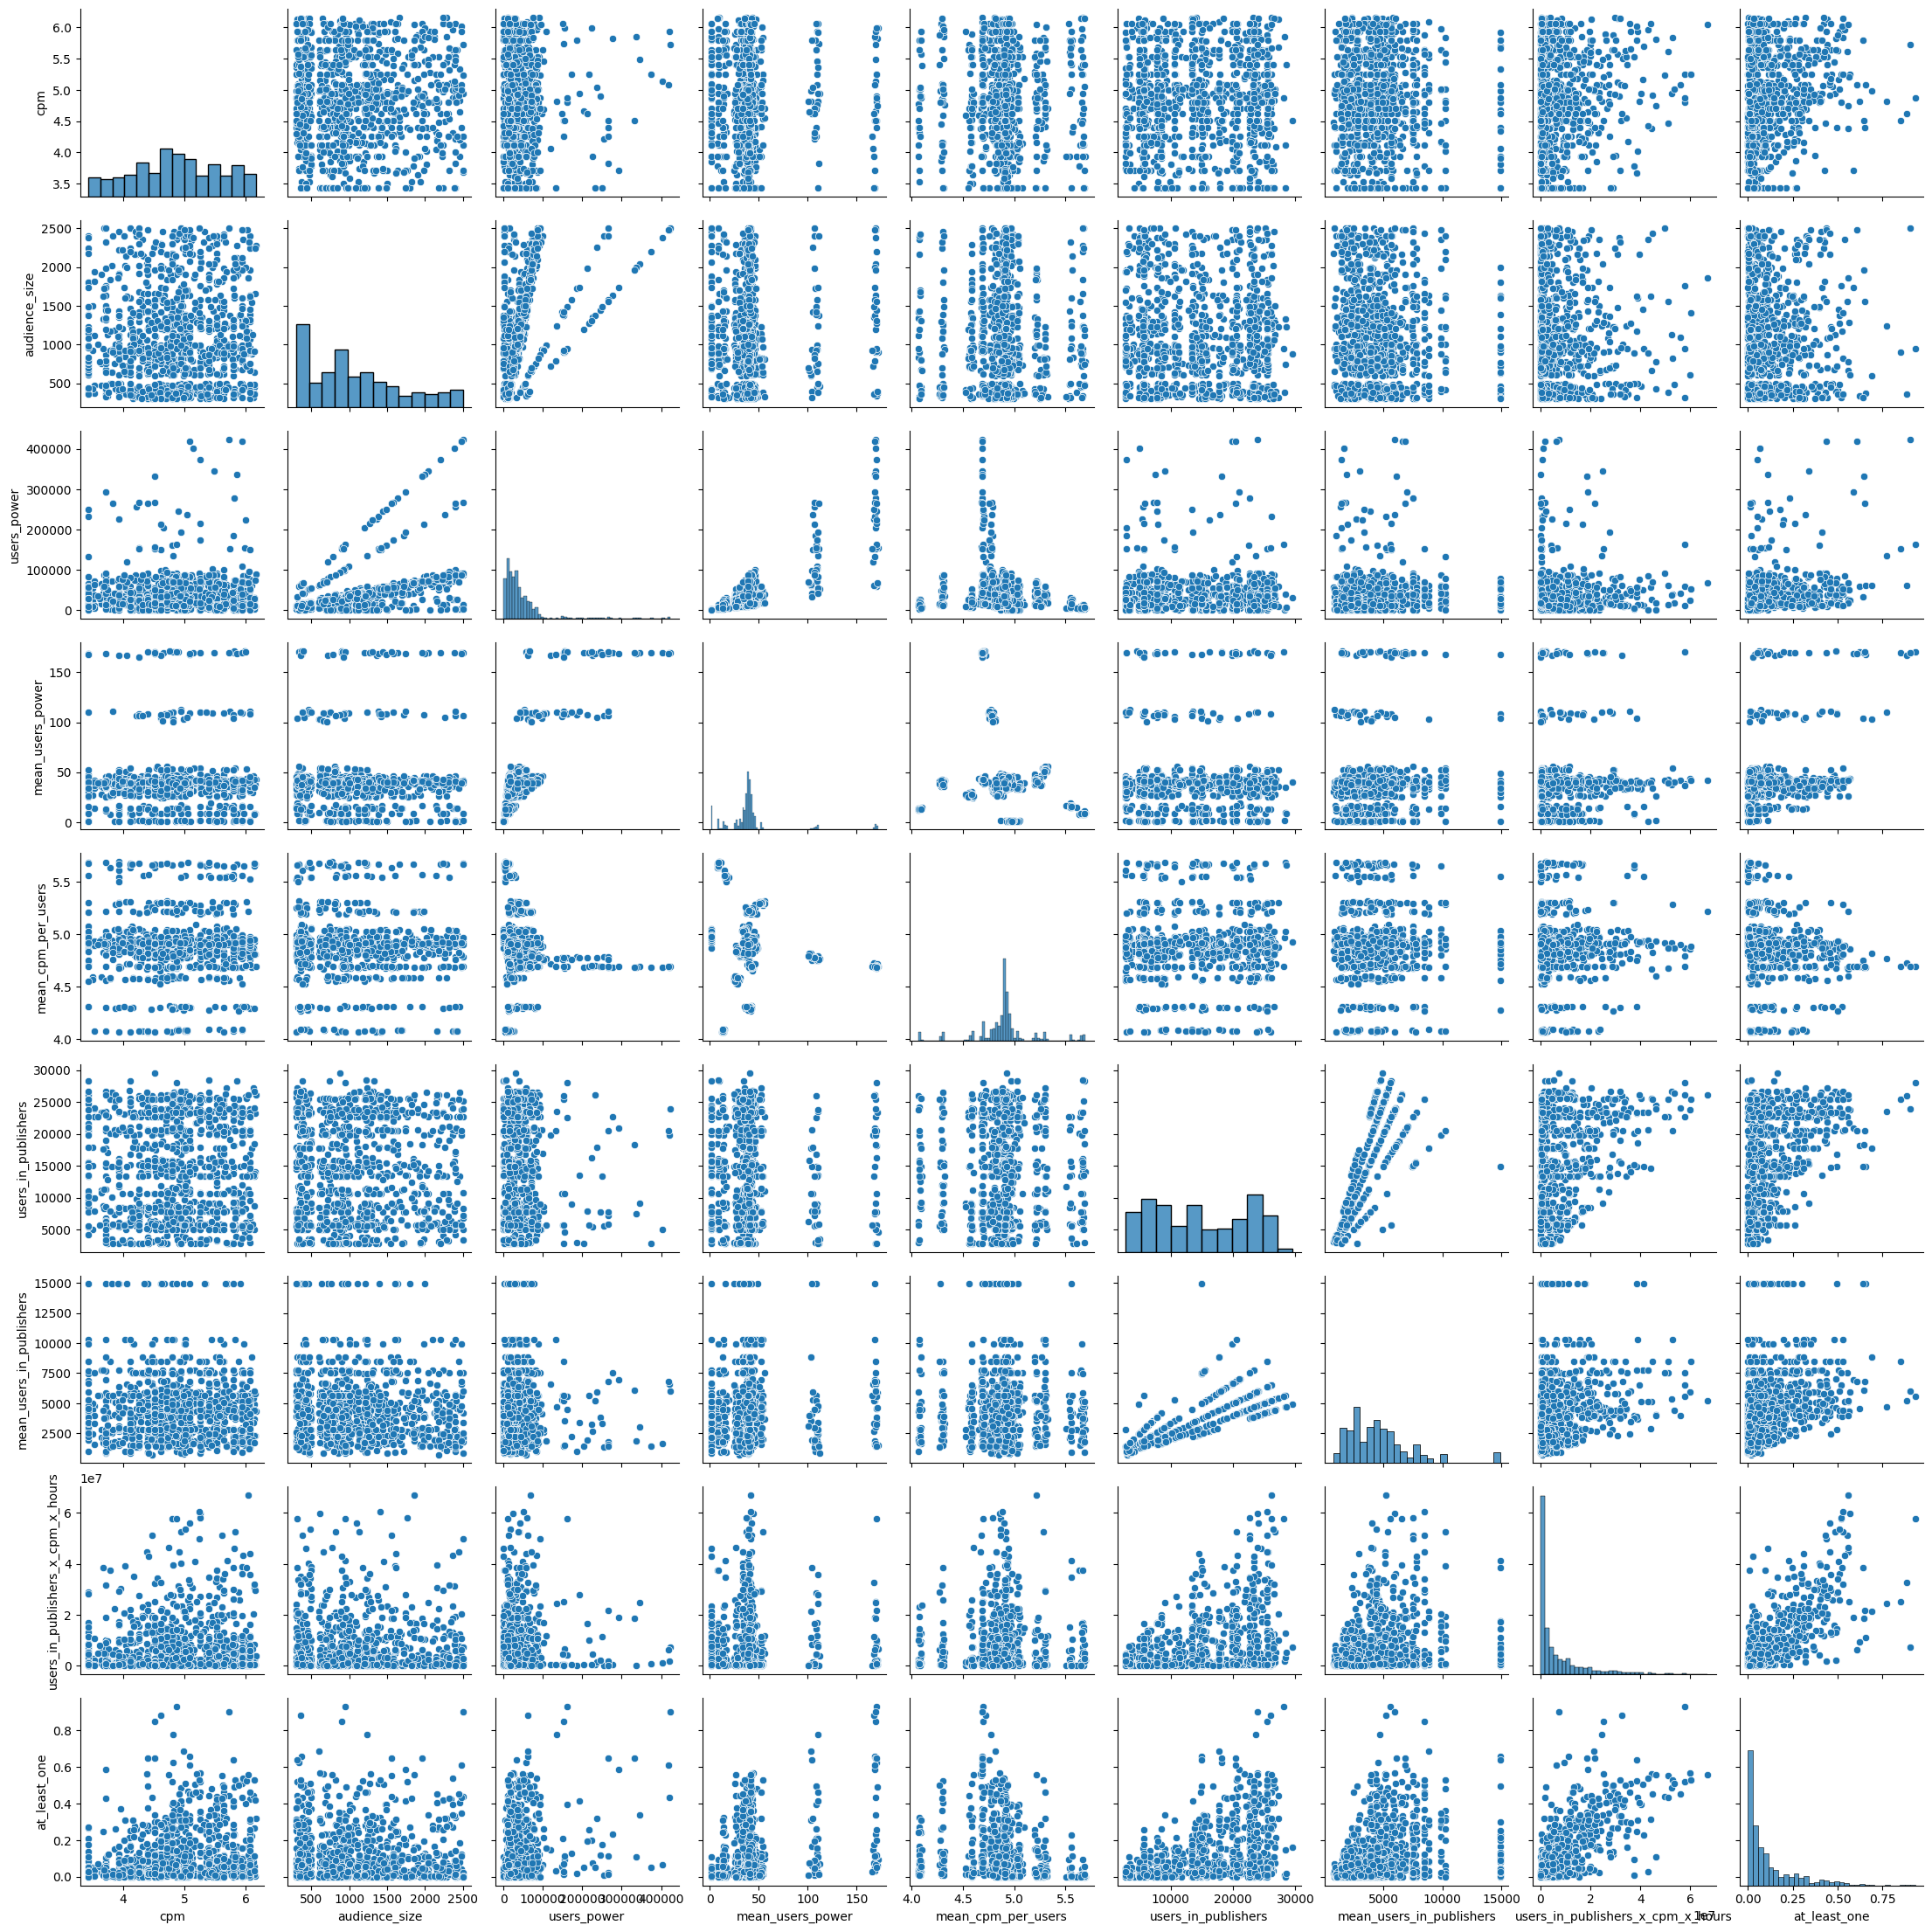

In [20]:
import seaborn as sns

sns.pairplot(features_and_target)

Тут также видим, что коррелирующий с таргетом признак относительно неплохо распределен, единственный минус - "ширина" этого распределения

Делим на train и test

In [21]:
from sklearn.model_selection import train_test_split

features_train, features_test, targets_train, targets_test = train_test_split(features, targets, test_size=0.33, random_state=42)

## Работа с моделью

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")

Используем CatBoostRegressor, потому что модель дает неплохой результат сходу (лучше чем у xgboost и GradientBoostingRegressor)

In [23]:
from catboost import CatBoostRegressor

In [24]:
X_train1, X_test1, y_train1, y_test1 = features_train, features_test, targets_train['at_least_one'], targets_test['at_least_one']

model1 = CatBoostRegressor(silent=True)
model1.fit(X_train1, y_train1)

y_true1 = np.array(y_test1)
y_pred1 = model1.predict(X_test1)

print_metrics(y_true1, y_pred1)

MAE: 0.0190
MSE: 0.0009
RMSE: 0.0294
R2: 0.9558


Посмотрим на значимость фичей  
Для этого будем использовать библиотеку SHAP

In [25]:
import shap

Инициализируем библиотеку

In [26]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer(X_train1)

Выведем фичи и их значимость

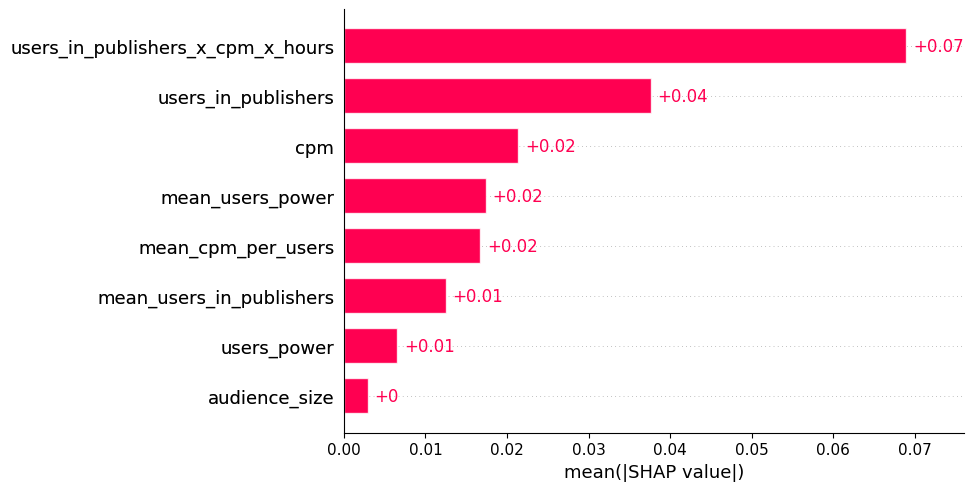

In [27]:
shap.plots.bar(shap_values)

Также выведем heatmap фич, чтобы увидеть как фичи описывают данные в совокупности (порядок семплов определен библиотекой на основе объясняемой схожести, т.е. библиотка применяет иерархическую кластеризацию для того, чтобы наиболее "объясняемые" с помощью наших фич были рядом друг с другом)

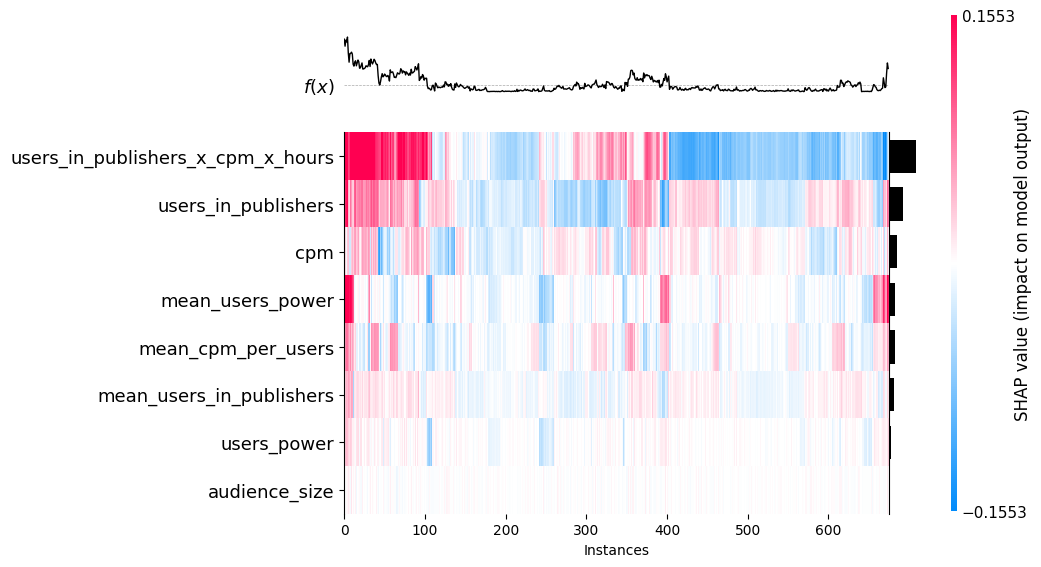

In [28]:
shap.plots.heatmap(shap_values);

Неплохо получается  
Возможно можно и  лучше  

График распределения значений

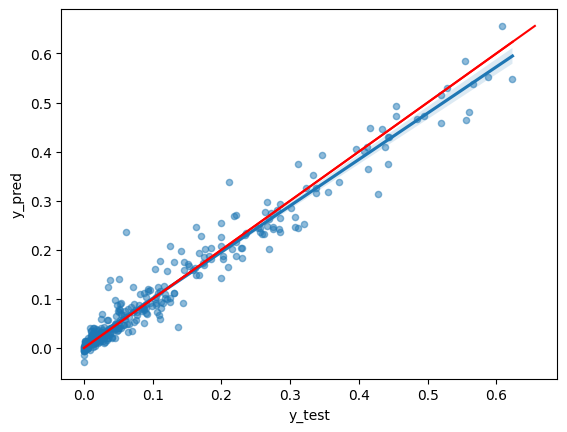

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

result1 = pd.DataFrame()
result1['y_test'] = y_test1
result1['y_pred'] = y_pred1

sns.regplot(data=result1, x='y_test', y='y_pred', scatter_kws={"s": 20, "alpha": 0.5})

x = np.linspace(0, result1.max(), 100)
plt.plot(x, x, color="red");

Видно, что есть некоторая ошибка (расхождение между линиями), но линии находятся близко друг к другу  
И это хорошо

Но это пока только один таргет, а нам надо еще 2

Во время анализа данных была выявлена сильная корреляция между таргетами  
Воспользуемся этим

Из всех опробованных моделей (GradientBoostingRegressor, CatBoostRegressor, LinearRegression) без оптимизации гиперпараметров лучше с задачей справляется GradientBoostingRegressor

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

Попробуем обучить (пока независимо) модели для регрессии двух оставшихся таргетов

In [31]:
X_train2, X_test2, y_train2, y_test2 = targets_train[['at_least_one']], targets_test[['at_least_one']], targets_train['at_least_two'], targets_test['at_least_two']

X_train2, X_test2, y_train2, y_test2 = X_train2, X_test2, y_train2, y_test2

model2 = GradientBoostingRegressor()
model2.fit(X_train2, y_train2)

y_pred2 = model2.predict(X_test2)

print_metrics(y_test2, y_pred2)

MAE: 0.0144
MSE: 0.0007
RMSE: 0.0267
R2: 0.9394


In [32]:
X_train3, X_test3, y_train3, y_test3 = targets_train[['at_least_two']], targets_test[['at_least_two']], targets_train['at_least_three'], targets_test['at_least_three']

model3 = GradientBoostingRegressor()
model3.fit(X_train3, y_train3)

y_pred3 = model3.predict(X_test3)

print_metrics(y_test3, y_pred3)

MAE: 0.0066
MSE: 0.0002
RMSE: 0.0132
R2: 0.9779


В целом получаются неплохие метрики

Теперь попробуем объединить модели в одну и посмотрим результат сразу на предложенной метрике

In [33]:
from metrics import get_smoothed_mean_log_accuracy_ratio

В baseline (все нули) метрика равна

In [34]:
baseline = pd.read_csv(os.path.join(data_dir, 'baseline.tsv'), sep='\t')
baseline_train, baseline_test = train_test_split(baseline, test_size=0.33, random_state=42)
get_smoothed_mean_log_accuracy_ratio(targets_test, baseline_test)

446.07

Нам надо сделать лучше)

У модели есть параметр, который отвечает за то будет ли каждая "следующая" суб-модель обучаться на результатах прошлой модели или будем обучать их независимо

In [35]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import GradientBoostingRegressor

class VKAdsRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, train_independently: bool = False):
        self.train_independently = train_independently
        self.model1 = CatBoostRegressor(silent=True)
        self.model2 = GradientBoostingRegressor()
        self.model3 = GradientBoostingRegressor()

    def fit(self, X, y):
        self.model1.fit(X, y['at_least_one'])
        
        if self.train_independently:
            self.model2.fit(y[['at_least_one']].to_numpy(), y['at_least_two'])
            self.model3.fit(y[['at_least_two']].to_numpy(), y['at_least_three'])
        else:
            output1 = np.clip(self.model1.predict(X), a_min=0, a_max=1).reshape(-1, 1)
            self.model2.fit(output1, y['at_least_two'])

            output2 = self.model2.predict(output1).reshape(-1, 1)
            self.model3.fit(output2, y['at_least_three'])

        return self

    def predict(self, X):
        output1 = np.clip(self.model1.predict(X), a_min=0, a_max=1)
        output2 = np.clip(self.model2.predict(output1.reshape(-1, 1)), a_min=0, a_max=1)
        output3 = np.clip(self.model3.predict(output2.reshape(-1, 1)), a_min=0, a_max=1)

        output = pd.DataFrame()
        output['at_least_one'] = output1
        output['at_least_two'] = output2
        output['at_least_three'] = output3
        output = output.set_index(X.index)
        
        return output

Для начала попробуем обучать независимо

In [36]:
model = VKAdsRegressor(train_independently=True)
model.fit(features_train, targets_train)

target_pred = model.predict(features_test)

get_smoothed_mean_log_accuracy_ratio(targets_test, target_pred)

46.38

А теперь попробуем во время обучения постараться учесть ошибки модели и каждую следующую суб-модель будем обучать, используя данные предыдущей суб-модели

In [37]:
model = VKAdsRegressor(train_independently=False)
model.fit(features_train, targets_train)

target_pred = model.predict(features_test)

get_smoothed_mean_log_accuracy_ratio(targets_test, target_pred)

49.1

Немного странно, но получилось так, что независимое обучение суб-моделей дало лучший результат  
В ряде экспериментов у меня получалось приблизить эти два значения друг к другу, но минимальная метрика становилась хуже

В итоге получили результат <50 по предложенной метрике, что однозначно лучше чем baseline)

Попробуем оптимизировать гиперпараметры моделей

Можно попробовать оптимизировать поэтапно, а можно все вместе  
Здесь приведен именно второй сценарий т.к. не всегда (хотя и в большинстве случаев) улучшение каждой модели по отдельности даст лучший результат в итоге  

Импортируем и конфигурируем optuna

In [38]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

Пишем функцию оптимизации

In [39]:
def optimize_sub_models(X_train, X_test, y_train, y_test, n_trials=50):
    def objective(trial):
        model1_params = {
            "iterations": trial.suggest_int("model1__iterations", 100, 1000),
            "depth": trial.suggest_int("model1__depth", 3, 10),
            "learning_rate": trial.suggest_float("model1__learning_rate", 1e-3, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("model1__l2_leaf_reg", 1e-3, 10.0, log=True),
            "border_count": trial.suggest_int("model1__border_count", 32, 255),
            "random_strength": trial.suggest_float("model1__random_strength", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("model1__bagging_temperature", 0.0, 1.0),
            "loss_function": "RMSE",
            "eval_metric": "RMSE",
            "random_seed": 42,
            "silent": True
        }

        model2_params = {
            "n_estimators": trial.suggest_int("model2__n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("model2__max_depth", 3, 10),
            "learning_rate": trial.suggest_float("model2__learning_rate", 1e-3, 0.3, log=True),
            "subsample": trial.suggest_float("model2__subsample", 0.5, 1.0),
            "min_samples_split": trial.suggest_int("model2__min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("model2__min_samples_leaf", 1, 20),
        }

        model3_params = {
            "n_estimators": trial.suggest_int("model3__n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("model3__max_depth", 3, 10),
            "learning_rate": trial.suggest_float("model3__learning_rate", 1e-3, 0.3, log=True),
            "subsample": trial.suggest_float("model3__subsample", 0.5, 1.0),
            "min_samples_split": trial.suggest_int("model3__min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("model3__min_samples_leaf", 1, 20),
        }

        model = VKAdsRegressor(train_independently=True)
        model.model1 = CatBoostRegressor(**model1_params)
        model.model2 = GradientBoostingRegressor(**model2_params)
        model.model3 = GradientBoostingRegressor(**model3_params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        metric = get_smoothed_mean_log_accuracy_ratio(y_test, y_pred)
        return metric

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True, n_jobs=-1)
    return study.best_params, study.best_value

Оптимизируем

In [40]:
optimize_sub_models(features_train, features_test, targets_train, targets_test, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

({'model1__iterations': 862,
  'model1__depth': 6,
  'model1__learning_rate': 0.0496391547137807,
  'model1__l2_leaf_reg': 0.023424237865293695,
  'model1__border_count': 149,
  'model1__random_strength': 0.0020552705861218465,
  'model1__bagging_temperature': 0.268436122813356,
  'model2__n_estimators': 867,
  'model2__max_depth': 9,
  'model2__learning_rate': 0.02470465993788557,
  'model2__subsample': 0.5773208405207791,
  'model2__min_samples_split': 12,
  'model2__min_samples_leaf': 18,
  'model3__n_estimators': 148,
  'model3__max_depth': 4,
  'model3__learning_rate': 0.2114270880021554,
  'model3__subsample': 0.520214927326297,
  'model3__min_samples_split': 12,
  'model3__min_samples_leaf': 6},
 42.51)

Получилось неплохо оптимизировать модель